# Bridge-T

![Schematic for the Bridge-T circuit](Bridge-T.png){#fig-bridge-t}  

## Introduction
A question posted on [electronics stackexchange](https://electronics.stackexchange.com/) by @lees2023 asked: 

>I'm trying to figure out how to formulate and solve some differential equations for this circuit. ... I run into an issue with the voltage/capacitor loop comprising Vin VC1 VC2 VC3 as I cannot arbitrarily assign an initial value to the voltage across C3.

@fig-bridge-t shows that the independent source V1 is connected to ground by the series connection of C1, C2 and C3. @lees2023 asked if the initial voltage on the capacitors, C1, C2 and C3 could violate [Kirchhoff's circuit laws](https://en.wikipedia.org/wiki/Kirchhoff%27s_circuit_laws) by leading to a situation where the initial voltage on the capacitors do not sum to a value equal to V1. For example, if V1 is equal to 1 volt and the initial voltage on the capacitors are each equal to one volt, the sum of the three initial voltages on the capacitors would be 3 volts and not sum to zero around the loop. @lees2023 provided some analysis in his question and discussed the voltage across C3 and stated that he needed to add a small series resistor to V1.

There were four answers provided by the comunity. The answer provided by @user347817 is long and detailed and in part 3 of his answer he adress the non zero initial condition and the transfer function at node 2. 

## Circuit description
The circuit shown in @fig-bridge-t has six branches and three nodes. The circuit has a three capacitor path from the independent source, V1 to ground. The circuit posted by @lees2023 didn't have any values for the components, so I'm going use values that are all set to one. The initial voltages on the capacitor can be set to any abritrairy value or left defaulted to zero volts. As described below, the circuit needs to be modified for the MNA. 

## Circuit analysis
@lees2023 asked for differential equations, but since this analysis is about using MNA, a frequency domain analysis will be presented. So I'm not going to derive the differential equations for the circuit. 

- transfer function at nodes 2 and 3
- Solve the equations for initial conditions
- compare to LTSpice results

Voltage sources, V2, v3 and V4 were added to the circuit shown in @fig-bridge-t-smna so that these sources can hold the capacitor's initial voltage value at time equal to 0+. Frequency domain equivilent of C with an initial voltage condition is a series voltage source v(0+)/s 

![Circuit used for MNA](Bridge-T-smna.png){#fig-bridge-t-smna} 

The net list for the circuit is:
```
V1 1 0 1
C2 4 1 1
C3 5 2 1
C1 6 2 1
L1 1 2 1
R1 3 0 1
V2 4 3 1
V3 6 0 1
V4 3 5 1
```

The following Python modules are used.

In [1]:
from sympy import *
import numpy as np
from tabulate import tabulate
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import SymMNA
from IPython.display import display, Markdown, Math, Latex
init_printing()

In [2]:
t = symbols('t',positive=True)  # t > 0

### Load the netlist
The netlist for @fig-bridge-t is pasted into the cell below and some edits were made to remove the inductor series resistance. 

In [3]:
net_list = '''
V1 1 0 1
C2 3 1 1
C3 3 2 1
C1 0 2 1
L 1 2 1
R2 3 0 1
'''

Generate the network equations.

In [4]:
report, network_df, df2, A, X, Z = SymMNA.smna(net_list)

# Put matricies into SymPy 
X = Matrix(X)
Z = Matrix(Z)

NE_sym = Eq(A*X,Z)

Generate markdown text to display the network equations.

In [5]:
temp = ''
for i in range(len(X)):
    temp += '${:s}$<br>'.format(latex(Eq((A*X)[i:i+1][0],Z[i])))

Markdown(temp)

$C_{2} s v_{1} - C_{2} s v_{3} + I_{L} + I_{V1} = 0$<br>$- C_{3} s v_{3} - I_{L} + v_{2} \left(C_{1} s + C_{3} s\right) = 0$<br>$- C_{2} s v_{1} - C_{3} s v_{2} + v_{3} \left(C_{2} s + C_{3} s + \frac{1}{R_{2}}\right) = 0$<br>$v_{1} = V_{1}$<br>$- I_{L} L s + v_{1} - v_{2} = 0$<br>

As shown above MNA generated many equations and these would be difficult to solve by hand and a symbolic soultion would take a lot of computing time. The equations are displace in matrix notation.

In [6]:
NE_sym

⎡      C₂⋅s⋅v₁ - C₂⋅s⋅v₃ + I_L + I_V1      ⎤       
⎢                                          ⎥   ⎡0 ⎤
⎢    -C₃⋅s⋅v₃ - I_L + v₂⋅(C₁⋅s + C₃⋅s)     ⎥   ⎢  ⎥
⎢                                          ⎥   ⎢0 ⎥
⎢                        ⎛              1 ⎞⎥   ⎢  ⎥
⎢-C₂⋅s⋅v₁ - C₃⋅s⋅v₂ + v₃⋅⎜C₂⋅s + C₃⋅s + ──⎟⎥ = ⎢0 ⎥
⎢                        ⎝              R₂⎠⎥   ⎢  ⎥
⎢                                          ⎥   ⎢V₁⎥
⎢                    v₁                    ⎥   ⎢  ⎥
⎢                                          ⎥   ⎣0 ⎦
⎣            -I_L⋅L⋅s + v₁ - v₂            ⎦       

The symbols generated by the Python code are extraced by the SymPy function free_symbols and then declared as SymPy variables. 

In [7]:
# turn the free symbols into SymPy variables
var(str(NE_sym.free_symbols).replace('{','').replace('}',''))

### Transfer function
Solving for the transfer function at node 2. Transfer functions are normally presented in the frequency domain and are steady state responses.

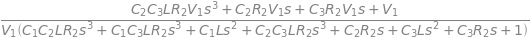

In [8]:
U_sym = solve(NE_sym,X)

H2_sym = U_sym[v2]/U_sym[v1]
H2_sym

Collecting the s terms:

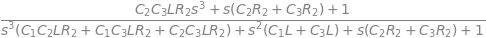

In [9]:
cancel(H2_sym,s)

My transfer function equation does not agree with the answer provided by @user347817.

Solving for the transfer function at node 3. 

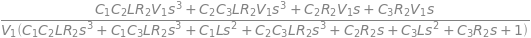

In [10]:
H3_sym = U_sym[v3]/U_sym[v1]
H3_sym

Collecting the s terms:

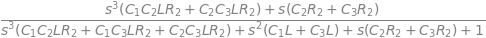

In [11]:
cancel(H3_sym,s)

My answer for the node 3 transfer function does not agree with the 1st answer's node 3 transfer function. 
SE answer: numerator

In [12]:
s*((C3+C2)*R2+(C1+C3)*L*R2*C2*s**2)

In [13]:
cancel(s*((C3+C2)*R2+(C1+C3)*L*R2*C2*s**2),s)

numerator agrees

denominator

In [14]:
(1+(C1+C3)*L*s**2)*(1+R2*C2*s)

In [15]:
cancel((1+(C1+C3)*L*s**2)*(1+R2*C2*s),s)

Denominator does not agree

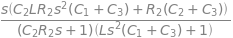

In [16]:
SE1 = (s*((C3+C2)*R2+(C1+C3)*L*R2*C2*s**2))/((1+(C1+C3)*L*s**2)*(1+R2*C2*s))
SE1

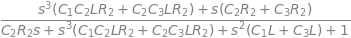

In [17]:
cancel(SE1,s)

### Include the initial conditions
Set initial conditions for C1, C2 and C3 by including independent voltage sources, V2, V3 and V4, and appling SymPy Heaveside function. The independent voltage source, V1 is a also a step function. Since V2, V3 and V4 are in series with capacitors, the steady state value of these sources is blocked and only the transient response is present. The netlist for @fig-bridge-t-smna is pasted into the cell below and some edits were made to remove the inductor series resistance and the independent sources are set to their DC values. 

In [18]:
net_list = '''
V1 1 0 1
C2 4 1 1
C3 5 2 1
C1 6 2 1
L 1 2 1
R2 3 0 1
V2 4 3 1
V3 6 0 1
V4 3 5 1
'''

Generate the network equations.

In [19]:
report, network_df, df2, A, X, Z = SymMNA.smna(net_list)

# Put matricies into SymPy 
X = Matrix(X)
Z = Matrix(Z)

NE_ic_sym = Eq(A*X,Z)

Generate markdown text to display the network equations.

In [20]:
temp = ''
for i in range(len(X)):
    temp += '${:s}$<br>'.format(latex(Eq((A*X)[i:i+1][0],Z[i])))

Markdown(temp)

$C_{2} s v_{1} - C_{2} s v_{4} + I_{L} + I_{V1} = 0$<br>$- C_{1} s v_{6} - C_{3} s v_{5} - I_{L} + v_{2} \left(C_{1} s + C_{3} s\right) = 0$<br>$- I_{V2} + I_{V4} + \frac{v_{3}}{R_{2}} = 0$<br>$- C_{2} s v_{1} + C_{2} s v_{4} + I_{V2} = 0$<br>$- C_{3} s v_{2} + C_{3} s v_{5} - I_{V4} = 0$<br>$- C_{1} s v_{2} + C_{1} s v_{6} + I_{V3} = 0$<br>$v_{1} = V_{1}$<br>$- v_{3} + v_{4} = V_{2}$<br>$v_{6} = V_{3}$<br>$v_{3} - v_{5} = V_{4}$<br>$- I_{L} L s + v_{1} - v_{2} = 0$<br>

As shown above MNA generated many equations and these would be difficult to solve by hand and a symbolic soultion would take a lot of computing time. The equations are displace in matrix notation.

In [21]:
NE_ic_sym

⎡      C₂⋅s⋅v₁ - C₂⋅s⋅v₄ + I_L + I_V1       ⎤       
⎢                                           ⎥   ⎡0 ⎤
⎢-C₁⋅s⋅v₆ - C₃⋅s⋅v₅ - I_L + v₂⋅(C₁⋅s + C₃⋅s)⎥   ⎢  ⎥
⎢                                           ⎥   ⎢0 ⎥
⎢                            v₃             ⎥   ⎢  ⎥
⎢             -I_V2 + I_V4 + ──             ⎥   ⎢0 ⎥
⎢                            R₂             ⎥   ⎢  ⎥
⎢                                           ⎥   ⎢0 ⎥
⎢         -C₂⋅s⋅v₁ + C₂⋅s⋅v₄ + I_V2         ⎥   ⎢  ⎥
⎢                                           ⎥   ⎢0 ⎥
⎢         -C₃⋅s⋅v₂ + C₃⋅s⋅v₅ - I_V4         ⎥   ⎢  ⎥
⎢                                           ⎥ = ⎢0 ⎥
⎢         -C₁⋅s⋅v₂ + C₁⋅s⋅v₆ + I_V3         ⎥   ⎢  ⎥
⎢                                           ⎥   ⎢V₁⎥
⎢                    v₁                     ⎥   ⎢  ⎥
⎢                                           ⎥   ⎢V₂⎥
⎢                 -v₃ + v₄                  ⎥   ⎢  ⎥
⎢                                           ⎥   ⎢V₃⎥
⎢                    v₆                     ⎥ 

The symbols generated by the Python code are extraced by the SymPy function free_symbols and then declared as SymPy variables. 

In [22]:
# turn the free symbols into SymPy variables
var(str(NE_ic_sym.free_symbols).replace('{','').replace('}',''))

The SymPy Heaviside function is used to define the initial current and voltage on the inductor and capacitor. The equivalent circuit in s domain has a capacitor C with impedance 1/(sC) and a voltage source v(0)/s in series.

In [23]:
NE_ic_sym = NE_ic_sym.subs({V1:laplace_transform(V1*Heaviside(t), t, s)[0], V2:laplace_transform(V2*Heaviside(t), t, s)[0], V3:laplace_transform(V3*Heaviside(t), t, s)[0], V4:laplace_transform(V4*Heaviside(t), t, s)[0]})
NE_ic_sym

                                                ⎡0 ⎤
                                                ⎢  ⎥
                                                ⎢0 ⎥
⎡      C₂⋅s⋅v₁ - C₂⋅s⋅v₄ + I_L + I_V1       ⎤   ⎢  ⎥
⎢                                           ⎥   ⎢0 ⎥
⎢-C₁⋅s⋅v₆ - C₃⋅s⋅v₅ - I_L + v₂⋅(C₁⋅s + C₃⋅s)⎥   ⎢  ⎥
⎢                                           ⎥   ⎢0 ⎥
⎢                            v₃             ⎥   ⎢  ⎥
⎢             -I_V2 + I_V4 + ──             ⎥   ⎢0 ⎥
⎢                            R₂             ⎥   ⎢  ⎥
⎢                                           ⎥   ⎢0 ⎥
⎢         -C₂⋅s⋅v₁ + C₂⋅s⋅v₄ + I_V2         ⎥   ⎢  ⎥
⎢                                           ⎥   ⎢V₁⎥
⎢         -C₃⋅s⋅v₂ + C₃⋅s⋅v₅ - I_V4         ⎥   ⎢──⎥
⎢                                           ⎥ = ⎢s ⎥
⎢         -C₁⋅s⋅v₂ + C₁⋅s⋅v₆ + I_V3         ⎥   ⎢  ⎥
⎢                                           ⎥   ⎢V₂⎥
⎢                    v₁                     ⎥   ⎢──⎥
⎢                                           ⎥ 

Generate and display the symbolic solution.

In [24]:
U_ic_sym = solve(NE_ic_sym,X)

temp = ''
for i in U_ic_sym.keys():
    temp += '${:s} = {:s}$<br>'.format(latex(i),latex(U_ic_sym[i]))

Markdown(temp)

$v_{1} = \frac{V_{1}}{s}$<br>$v_{2} = \frac{C_{1} C_{2} L R_{2} V_{3} s^{3} + C_{1} C_{3} L R_{2} V_{3} s^{3} + C_{1} L V_{3} s^{2} + C_{2} C_{3} L R_{2} V_{1} s^{3} - C_{2} C_{3} L R_{2} V_{2} s^{3} - C_{2} C_{3} L R_{2} V_{4} s^{3} + C_{2} R_{2} V_{1} s - C_{3} L V_{4} s^{2} + C_{3} R_{2} V_{1} s + V_{1}}{C_{1} C_{2} L R_{2} s^{4} + C_{1} C_{3} L R_{2} s^{4} + C_{1} L s^{3} + C_{2} C_{3} L R_{2} s^{4} + C_{2} R_{2} s^{2} + C_{3} L s^{3} + C_{3} R_{2} s^{2} + s}$<br>$v_{3} = \frac{C_{1} C_{2} L R_{2} V_{1} s^{2} - C_{1} C_{2} L R_{2} V_{2} s^{2} + C_{1} C_{3} L R_{2} V_{3} s^{2} + C_{1} C_{3} L R_{2} V_{4} s^{2} + C_{2} C_{3} L R_{2} V_{1} s^{2} - C_{2} C_{3} L R_{2} V_{2} s^{2} + C_{2} R_{2} V_{1} - C_{2} R_{2} V_{2} + C_{3} R_{2} V_{1} + C_{3} R_{2} V_{4}}{C_{1} C_{2} L R_{2} s^{3} + C_{1} C_{3} L R_{2} s^{3} + C_{1} L s^{2} + C_{2} C_{3} L R_{2} s^{3} + C_{2} R_{2} s + C_{3} L s^{2} + C_{3} R_{2} s + 1}$<br>$v_{4} = \frac{C_{1} C_{2} L R_{2} V_{1} s^{3} + C_{1} C_{3} L R_{2} V_{2} s^{3} + C_{1} C_{3} L R_{2} V_{3} s^{3} + C_{1} C_{3} L R_{2} V_{4} s^{3} + C_{1} L V_{2} s^{2} + C_{2} C_{3} L R_{2} V_{1} s^{3} + C_{2} R_{2} V_{1} s + C_{3} L V_{2} s^{2} + C_{3} R_{2} V_{1} s + C_{3} R_{2} V_{2} s + C_{3} R_{2} V_{4} s + V_{2}}{C_{1} C_{2} L R_{2} s^{4} + C_{1} C_{3} L R_{2} s^{4} + C_{1} L s^{3} + C_{2} C_{3} L R_{2} s^{4} + C_{2} R_{2} s^{2} + C_{3} L s^{3} + C_{3} R_{2} s^{2} + s}$<br>$v_{5} = \frac{C_{1} C_{2} L R_{2} V_{1} s^{3} - C_{1} C_{2} L R_{2} V_{2} s^{3} - C_{1} C_{2} L R_{2} V_{4} s^{3} + C_{1} C_{3} L R_{2} V_{3} s^{3} - C_{1} L V_{4} s^{2} + C_{2} C_{3} L R_{2} V_{1} s^{3} - C_{2} C_{3} L R_{2} V_{2} s^{3} - C_{2} C_{3} L R_{2} V_{4} s^{3} + C_{2} R_{2} V_{1} s - C_{2} R_{2} V_{2} s - C_{2} R_{2} V_{4} s - C_{3} L V_{4} s^{2} + C_{3} R_{2} V_{1} s - V_{4}}{C_{1} C_{2} L R_{2} s^{4} + C_{1} C_{3} L R_{2} s^{4} + C_{1} L s^{3} + C_{2} C_{3} L R_{2} s^{4} + C_{2} R_{2} s^{2} + C_{3} L s^{3} + C_{3} R_{2} s^{2} + s}$<br>$v_{6} = \frac{V_{3}}{s}$<br>$I_{V1} = \frac{- C_{1} C_{2} C_{3} L R_{2} V_{1} s^{3} + C_{1} C_{2} C_{3} L R_{2} V_{2} s^{3} + C_{1} C_{2} C_{3} L R_{2} V_{3} s^{3} + C_{1} C_{2} C_{3} L R_{2} V_{4} s^{3} - C_{1} C_{2} L V_{1} s^{2} + C_{1} C_{2} L V_{2} s^{2} - C_{1} C_{2} R_{2} V_{1} s + C_{1} C_{2} R_{2} V_{3} s - C_{1} C_{3} R_{2} V_{1} s + C_{1} C_{3} R_{2} V_{3} s - C_{1} V_{1} + C_{1} V_{3} - C_{2} C_{3} L V_{1} s^{2} + C_{2} C_{3} L V_{2} s^{2} - C_{2} V_{1} + C_{2} V_{2} - C_{3} V_{1} - C_{3} V_{4}}{C_{1} C_{2} L R_{2} s^{3} + C_{1} C_{3} L R_{2} s^{3} + C_{1} L s^{2} + C_{2} C_{3} L R_{2} s^{3} + C_{2} R_{2} s + C_{3} L s^{2} + C_{3} R_{2} s + 1}$<br>$I_{V2} = \frac{C_{1} C_{2} C_{3} L R_{2} V_{1} s^{3} - C_{1} C_{2} C_{3} L R_{2} V_{2} s^{3} - C_{1} C_{2} C_{3} L R_{2} V_{3} s^{3} - C_{1} C_{2} C_{3} L R_{2} V_{4} s^{3} + C_{1} C_{2} L V_{1} s^{2} - C_{1} C_{2} L V_{2} s^{2} + C_{2} C_{3} L V_{1} s^{2} - C_{2} C_{3} L V_{2} s^{2} - C_{2} C_{3} R_{2} V_{2} s - C_{2} C_{3} R_{2} V_{4} s + C_{2} V_{1} - C_{2} V_{2}}{C_{1} C_{2} L R_{2} s^{3} + C_{1} C_{3} L R_{2} s^{3} + C_{1} L s^{2} + C_{2} C_{3} L R_{2} s^{3} + C_{2} R_{2} s + C_{3} L s^{2} + C_{3} R_{2} s + 1}$<br>$I_{V3} = \frac{C_{1} C_{2} C_{3} L R_{2} V_{1} s^{3} - C_{1} C_{2} C_{3} L R_{2} V_{2} s^{3} - C_{1} C_{2} C_{3} L R_{2} V_{3} s^{3} - C_{1} C_{2} C_{3} L R_{2} V_{4} s^{3} + C_{1} C_{2} R_{2} V_{1} s - C_{1} C_{2} R_{2} V_{3} s - C_{1} C_{3} L V_{3} s^{2} - C_{1} C_{3} L V_{4} s^{2} + C_{1} C_{3} R_{2} V_{1} s - C_{1} C_{3} R_{2} V_{3} s + C_{1} V_{1} - C_{1} V_{3}}{C_{1} C_{2} L R_{2} s^{3} + C_{1} C_{3} L R_{2} s^{3} + C_{1} L s^{2} + C_{2} C_{3} L R_{2} s^{3} + C_{2} R_{2} s + C_{3} L s^{2} + C_{3} R_{2} s + 1}$<br>$I_{V4} = \frac{C_{1} C_{2} C_{3} L R_{2} V_{1} s^{3} - C_{1} C_{2} C_{3} L R_{2} V_{2} s^{3} - C_{1} C_{2} C_{3} L R_{2} V_{3} s^{3} - C_{1} C_{2} C_{3} L R_{2} V_{4} s^{3} - C_{1} C_{3} L V_{3} s^{2} - C_{1} C_{3} L V_{4} s^{2} - C_{2} C_{3} R_{2} V_{2} s - C_{2} C_{3} R_{2} V_{4} s - C_{3} V_{1} - C_{3} V_{4}}{C_{1} C_{2} L R_{2} s^{3} + C_{1} C_{3} L R_{2} s^{3} + C_{1} L s^{2} + C_{2} C_{3} L R_{2} s^{3} + C_{2} R_{2} s + C_{3} L s^{2} + C_{3} R_{2} s + 1}$<br>$I_{L} = \frac{C_{1} C_{2} R_{2} V_{1} s - C_{1} C_{2} R_{2} V_{3} s + C_{1} C_{3} R_{2} V_{1} s - C_{1} C_{3} R_{2} V_{3} s + C_{1} V_{1} - C_{1} V_{3} + C_{2} C_{3} R_{2} V_{2} s + C_{2} C_{3} R_{2} V_{4} s + C_{3} V_{1} + C_{3} V_{4}}{C_{1} C_{2} L R_{2} s^{3} + C_{1} C_{3} L R_{2} s^{3} + C_{1} L s^{2} + C_{2} C_{3} L R_{2} s^{3} + C_{2} R_{2} s + C_{3} L s^{2} + C_{3} R_{2} s + 1}$<br>

Network equations and solution in symbolic form are seaily obtained. These equations are in the frequency domain and if transformed back to the time domain, they would be differential equations. But not necessarily in the form of state equations. In this case the equations are a little too long to provide any insight into the operation of the circuit.

## Initial conditions with component values
Get element values from network dataframe. As describe above, the orginal question didn't have values associated with the components, so I'm using a value of one for all the values.

In [25]:
element_values = SymMNA.get_part_values(network_df)
element_values

In [26]:
NE_ic = NE_ic_sym.subs(element_values)
NE_ic

                                  ⎡ 0 ⎤
                                  ⎢   ⎥
                                  ⎢ 0 ⎥
                                  ⎢   ⎥
⎡I_L + I_V1 + 1.0⋅s⋅v₁ - s⋅v₄ ⎤   ⎢ 0 ⎥
⎢                             ⎥   ⎢   ⎥
⎢-I_L + 2.0⋅s⋅v₂ - s⋅v₅ - s⋅v₆⎥   ⎢ 0 ⎥
⎢                             ⎥   ⎢   ⎥
⎢    -I_V2 + I_V4 + 1.0⋅v₃    ⎥   ⎢ 0 ⎥
⎢                             ⎥   ⎢   ⎥
⎢   I_V2 - s⋅v₁ + 1.0⋅s⋅v₄    ⎥   ⎢ 0 ⎥
⎢                             ⎥   ⎢   ⎥
⎢   -I_V4 - s⋅v₂ + 1.0⋅s⋅v₅   ⎥   ⎢1.0⎥
⎢                             ⎥   ⎢───⎥
⎢   I_V3 - s⋅v₂ + 1.0⋅s⋅v₆    ⎥ = ⎢ s ⎥
⎢                             ⎥   ⎢   ⎥
⎢             v₁              ⎥   ⎢1.0⎥
⎢                             ⎥   ⎢───⎥
⎢          -v₃ + v₄           ⎥   ⎢ s ⎥
⎢                             ⎥   ⎢   ⎥
⎢             v₆              ⎥   ⎢1.0⎥
⎢                             ⎥   ⎢───⎥
⎢           v₃ - v₅           ⎥   ⎢ s ⎥
⎢                             ⎥   ⎢   ⎥
⎣      -I_L⋅s + v₁ - v₂       ⎦   ⎢1.0⎥


Solve the network equations and display the results.

In [27]:
U_ic = solve(NE_ic,X)

temp = ''
for i in U_ic.keys():
    temp += '${:s} = {:s}$<br>'.format(latex(i),latex(U_ic[i]))

Markdown(temp)

$v_{1} = \frac{1}{s}$<br>$v_{2} = \frac{s^{3} + 2.0 s + 1.0}{3.0 s^{4} + 2.0 s^{3} + 2.0 s^{2} + s}$<br>$v_{3} = \frac{2.0 s^{2} + 2.0}{3.0 s^{3} + 2.0 s^{2} + 2.0 s + 1.0}$<br>$v_{4} = \frac{5.0 s^{3} + 2.0 s^{2} + 4.0 s + 1.0}{3.0 s^{4} + 2.0 s^{3} + 2.0 s^{2} + s}$<br>$v_{5} = \frac{- s^{3} - 2.0 s^{2} - 1.0}{3.0 s^{4} + 2.0 s^{3} + 2.0 s^{2} + s}$<br>$v_{6} = \frac{1}{s}$<br>$I_{V1} = \frac{2.0 s^{3} - 2.0}{3.0 s^{3} + 2.0 s^{2} + 2.0 s + 1.0}$<br>$I_{V2} = \frac{- 2.0 s^{3} - 2.0 s}{3.0 s^{3} + 2.0 s^{2} + 2.0 s + 1.0}$<br>$I_{V3} = \frac{- 2.0 s^{3} - 2.0 s^{2}}{3.0 s^{3} + 2.0 s^{2} + 2.0 s + 1.0}$<br>$I_{V4} = \frac{- 2.0 s^{3} - 2.0 s^{2} - 2.0 s - 2.0}{3.0 s^{3} + 2.0 s^{2} + 2.0 s + 1.0}$<br>$I_{L} = \frac{2.0 s + 2.0}{3.0 s^{3} + 2.0 s^{2} + 2.0 s + 1.0}$<br>

## Node 2 voltage

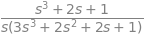

In [28]:
node2 = U_ic[v2].nsimplify().simplify().expand().together()
node2

The inverse Laplace was taking too long, so the lines of code were commented out

In [29]:
#node_2_voltage = inverse_laplace_transform(temp, s, t)
#node_2_voltage

Using NumPy to obtain the partial fraction expansion, convert back to the s domain and then take the inverse Laplace transform on each term.

Extract the numerator and denominator and display.

In [30]:
n, d = fraction(node2)
n = n.expand()
Markdown('numerator: ${:s}$<br>denominator: ${:s}$'.format(latex(n),latex(d)))

numerator: $s^{3} + 2 s + 1$<br>denominator: $s \left(3 s^{3} + 2 s^{2} + 2 s + 1\right)$

Each of the numerator terms can be put over the common denominator.

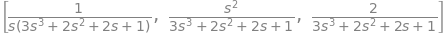

In [31]:
terms = [a / d for a in n.args]
display(terms)

The following code processes each of the terms obtained above. 

- the SciPy function [residue](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.residue.html) is used to get the residues and poles of the partial-fraction expansion
- build the partial expansion terms and find the inverse Laplace of each term and save

Returns:

- r: Residues corresponding to the poles. For repeated poles, the residues are ordered to correspond to ascending by power fractions.
- p: Poles ordered by magnitude in ascending order.
- k: Coefficients of the direct polynomial term.

When computing the inverse Laplace transform, the Coefficients (k) are ignored since these transform to a Dirac delta function, $\delta (t)$ and don't need to be plotted.

In [32]:
N = []

for p in terms:

    # use the SciPy residue function to get the partial-fraction expansion residues and poles
    n, d = fraction(p)
    cn = Poly(n, s).all_coeffs()
    cd = Poly(d, s).all_coeffs()
    r, p, k = signal.residue(cn, cd, tol=0.001, rtype='avg')

    # build a symbolic expression for each of the residues and find the inverse Laplace of each one and save
    z = 0
    for i in range(len(r)):
        m = (r[i]/(s-p[i]))
        z += inverse_laplace_transform(m, s, t)

    N.append(z)

Each of these terms came be converted to a function using SymPy's [lambdify](https://docs.sympy.org/latest/modules/utilities/lambdify.html) function.

Define the values for the x-axis of the plot and put each one into an array for plotting.

In [33]:
x = np.linspace(0, 50, 2000, endpoint=True)
V_node2 = np.zeros(len(x),dtype = complex)
for p in N:
    V_node2 += lambdify(t, p)(x)

Plot the final combined result.

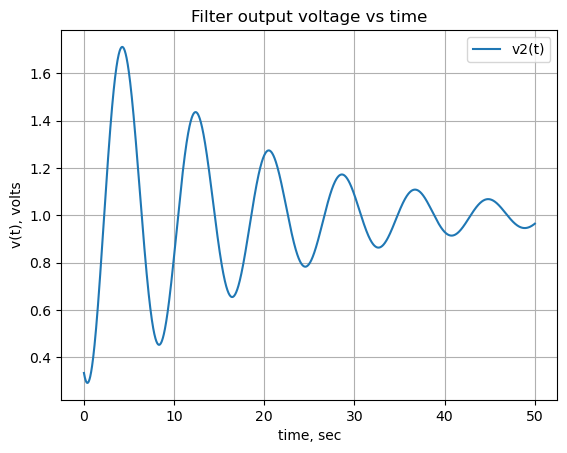

In [34]:
plt.title('Filter output voltage vs time')

plt.plot(x, np.real(V_node2),label='v2(t)')
#plt.plot(x, np.real(func_V1_t(x)),label='V1(t)')

plt.ylabel('v(t), volts')
plt.xlabel('time, sec')

plt.legend()
plt.grid()
plt.show()

## Node 3 voltage
The voltage on node 3 is symplified with the chain of operators applied to the expression; [nsimplify()](https://docs.sympy.org/latest/modules/simplify/simplify.html#sympy.simplify.simplify.nsimplify), [simplify()](https://docs.sympy.org/latest/modules/simplify/simplify.html#simplify), [expand()](https://docs.sympy.org/latest/modules/core.html#sympy.core.function.expand) and [together()](https://docs.sympy.org/latest/modules/polys/reference.html#sympy.polys.rationaltools.together). This helps SymPy solve the inverse Laplace transform.

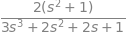

In [35]:
node3 = U_ic[v3].nsimplify().simplify().expand().together()
node3

The inverse Laplace was taking too long, so the lines of code were commented out

In [36]:
#node_2_voltage = inverse_laplace_transform(temp, s, t)
#node_2_voltage

Using NumPy

Extract the numerator and denominator and display.

In [37]:
n, d = fraction(node3)
n = n.expand()
Markdown('numerator: ${:s}$<br>denominator: ${:s}$'.format(latex(n),latex(d)))

numerator: $2 s^{2} + 2$<br>denominator: $3 s^{3} + 2 s^{2} + 2 s + 1$

Each of the numerator terms can be put over the common denominator.

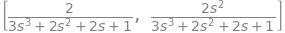

In [38]:
terms = [a / d for a in n.args]
display(terms)

Process term as decribed above. 

In [39]:
N = []

for p in terms:

    # use the SciPy residue function to get the partial-fraction expansion residues and poles
    n, d = fraction(p)
    cn = Poly(n, s).all_coeffs()
    cd = Poly(d, s).all_coeffs()
    r, p, k = signal.residue(cn, cd, tol=0.001, rtype='avg')

    # build a symbolic expression for each of the residues and find the inverse Laplace of each one and save
    z = 0
    for i in range(len(r)):
        m = (r[i]/(s-p[i]))
        z += inverse_laplace_transform(m, s, t)

    N.append(z)

Sum all the terms.

In [40]:
x = np.linspace(0, 50, 2000, endpoint=True)
V_node3 = np.zeros(len(x),dtype = complex)
for p in N:
    V_node3 += lambdify(t, p)(x)

Plot the final combined result.

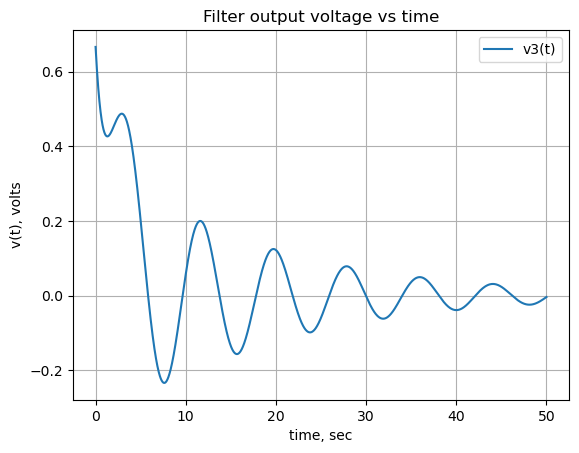

In [41]:
plt.title('Filter output voltage vs time')

plt.plot(x, np.real(V_node3),label='v3(t)')
#plt.plot(x, np.real(func_V1_t(x)),label='V1(t)')

plt.ylabel('v(t), volts')
plt.xlabel('time, sec')

plt.legend()
plt.grid()
plt.show()

## LTSpice Solution
To chech the Python results the circuit was simulated in LTSpice. The following schematice was used and the LTSpice results are also shown below.

![Circuit used for LTSpice analysis](Bridge-T-LTSpice.png){#fig-bridge-LTPpice} 

![Plot from LTSpice of node voltages](Bridge-T-LTSpice-plot.png){#fig-bridge-LTSpice-plot} 

Load the csv file LTSpice results and plot along with the results obtained from Python.

In [42]:
fn = 'Bridge-T-LTSpice.csv' # data from LTSpice
LTSpice_data = np.genfromtxt(fn, delimiter=',',skip_header=1)

Copy the data from the csv file into NumPy arrays.

In [43]:
# initaliase some empty arrays
time = np.zeros(len(LTSpice_data))
voltage1 = np.zeros(len(LTSpice_data))
voltage2 = np.zeros(len(LTSpice_data))
voltage3 = np.zeros(len(LTSpice_data))

# convert the csv data to complez numbers and store in the array
for i in range(len(LTSpice_data)):
    time[i] = LTSpice_data[i][0]
    voltage1[i] = LTSpice_data[i][1]
    voltage2[i] = LTSpice_data[i][2]
    voltage3[i] = LTSpice_data[i][3]

Plot the LTSpice data and the Python data to see if they agree.

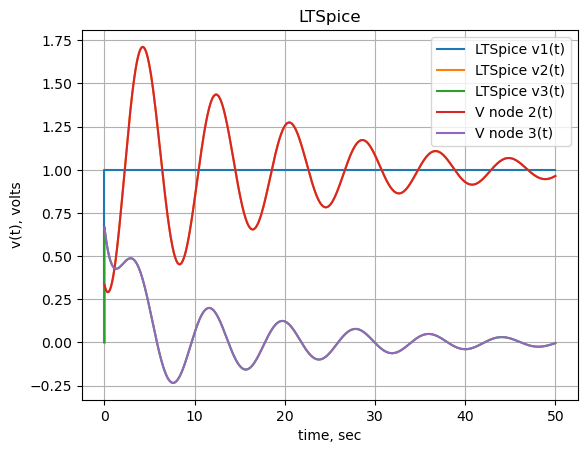

In [44]:
plt.title('LTSpice')

plt.plot(time, voltage1,label='LTSpice v1(t)')
plt.plot(time, voltage2,label='LTSpice v2(t)')
plt.plot(time, voltage3,label='LTSpice v3(t)')

plt.plot(x, np.real(V_node2),label='V node 2(t)')
plt.plot(x, np.real(V_node3),label='V node 3(t)')
#plt.plot(x, np.real(func_V1_t(x)),label='V1(t)')

plt.ylabel('v(t), volts')
plt.xlabel('time, sec')

plt.legend()
plt.grid()
plt.show()

As shown in the plot above, the curves superimpose.

## Summary
In this notebook, newtork equations were solved which had initial conditions. The independent voltage source, V1 was modeled as a step function. The initial voltages on each of the capacitors were also modeled as step functions equal to the initial voltage. The network equations were generated with MNA and SymPy was used to solve the system of equations. The results were compared to results from LTSpice and the curves superimpose. 

The MNA procedure and LTSpice didn't have any issues with initial conditions. At t=0, all the voltages and currents in the circuit comply with Kirchhoff's circuit laws (KCL) since the Heavyside function at t=0 is zero. At t=0+, where the + indicates the next infinitesimal instant in time, the voltages and currents would comply with KCL and result in large current flows to accomidate the solution for the voltages. Both Python and LTSpice step through time in discreate amounts, and at each step time KCL is satisified. I don't think this was explained in any of the answers provided. 

The answers provide by @user347817 are different from the results I obtained and he did not provide a time domain solution and plots of the node voltages.

$\large{\color {red} {\text{Explain results when V4 is rotated}}}$  